# Modificaciones Alonso Código

In [127]:
from piping_functions import *
from tabulate import tabulate
import CoolProp.CoolProp as CP
import matplotlib.cm as cm
import matplotlib.pyplot as plt

### Tuberías dentro de cada departamento

Diámetro horizontal nominal: 25 mm

Diámetro horizontal interior: 19.4 mm (S4 PN 12.5)

### Tuberías dentro de cada piso

Diámetro horizontal nominal: 32 mm

Diámetro horizontal interior: 24.8 mm (S4 PN 12.5)

### Tuberías en la vertical de cada piso

Diámetro horizontal nominal: 110 mm

Diámetro horizontal interior: 85.4 mm (S4 PN 12.5).

https://reboca.com/wp-content/uploads/manual-tecnico-es.pdf

![rugosidad PPR.png](<attachment:rugosidad PPR.png>)
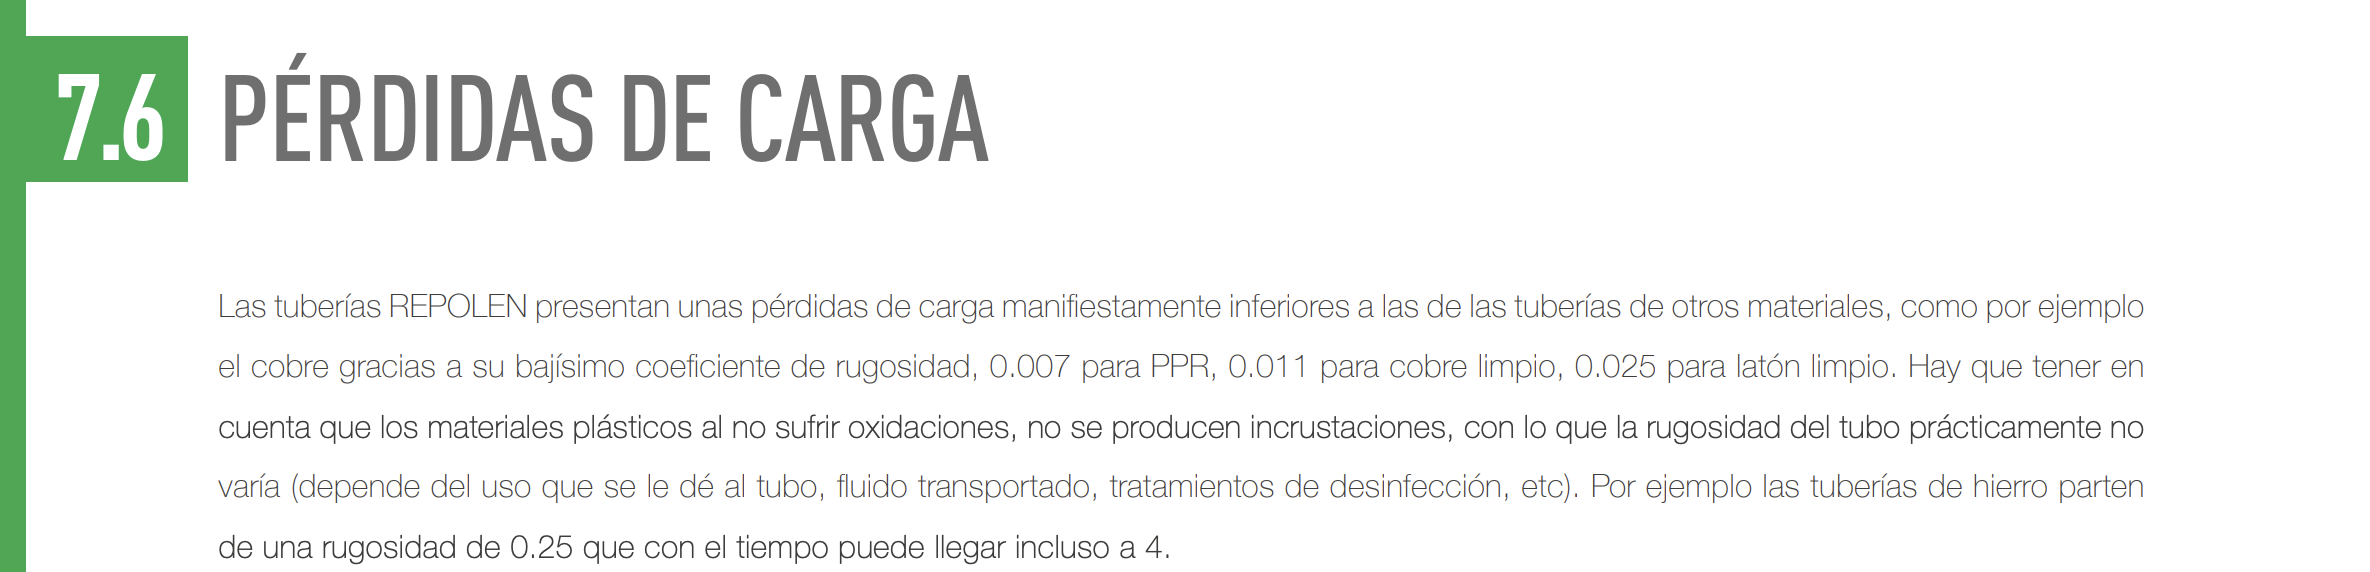

Rugosidad PPR: 0.007 mm

In [128]:
diametro_horizontal_nominal = 25e-3 # m
diametro_horizontal_interno = 19.4e-3  # m
diametro_piso_nominal = 32e-3 # m
diametro_piso_interno = 24.8e-3  # m
diametro_vertical_nominal = 90e-3 # m
diametro_vertical_interno = 69.8e-3  # m
rugosidad_ppr = 0.007e-3 # m

caudal_sin_factor = 5.67e-3 # m3/s
presion_adicional = 1.524 * 1000 * 9.81 # Pa (presión por escoger la bomba con diámetro de 9.5" del rodete)

### Clase Dispositivos:

Clase que calcula la caída de presión en el tramo hasta cada dispositivo, así como la presión al final del dispositivo. Recibe como parámetro la presión que ingresa al departamento. 

![Diagrama Deparamento.png](<attachment:Diagrama Deparamento.png>)
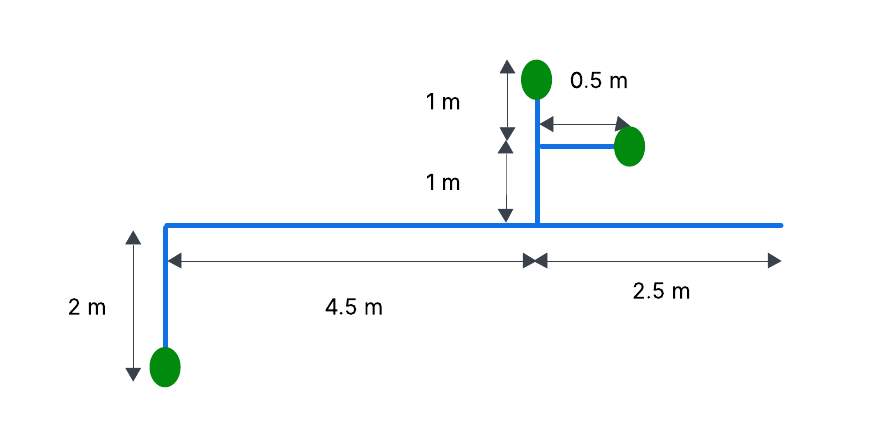

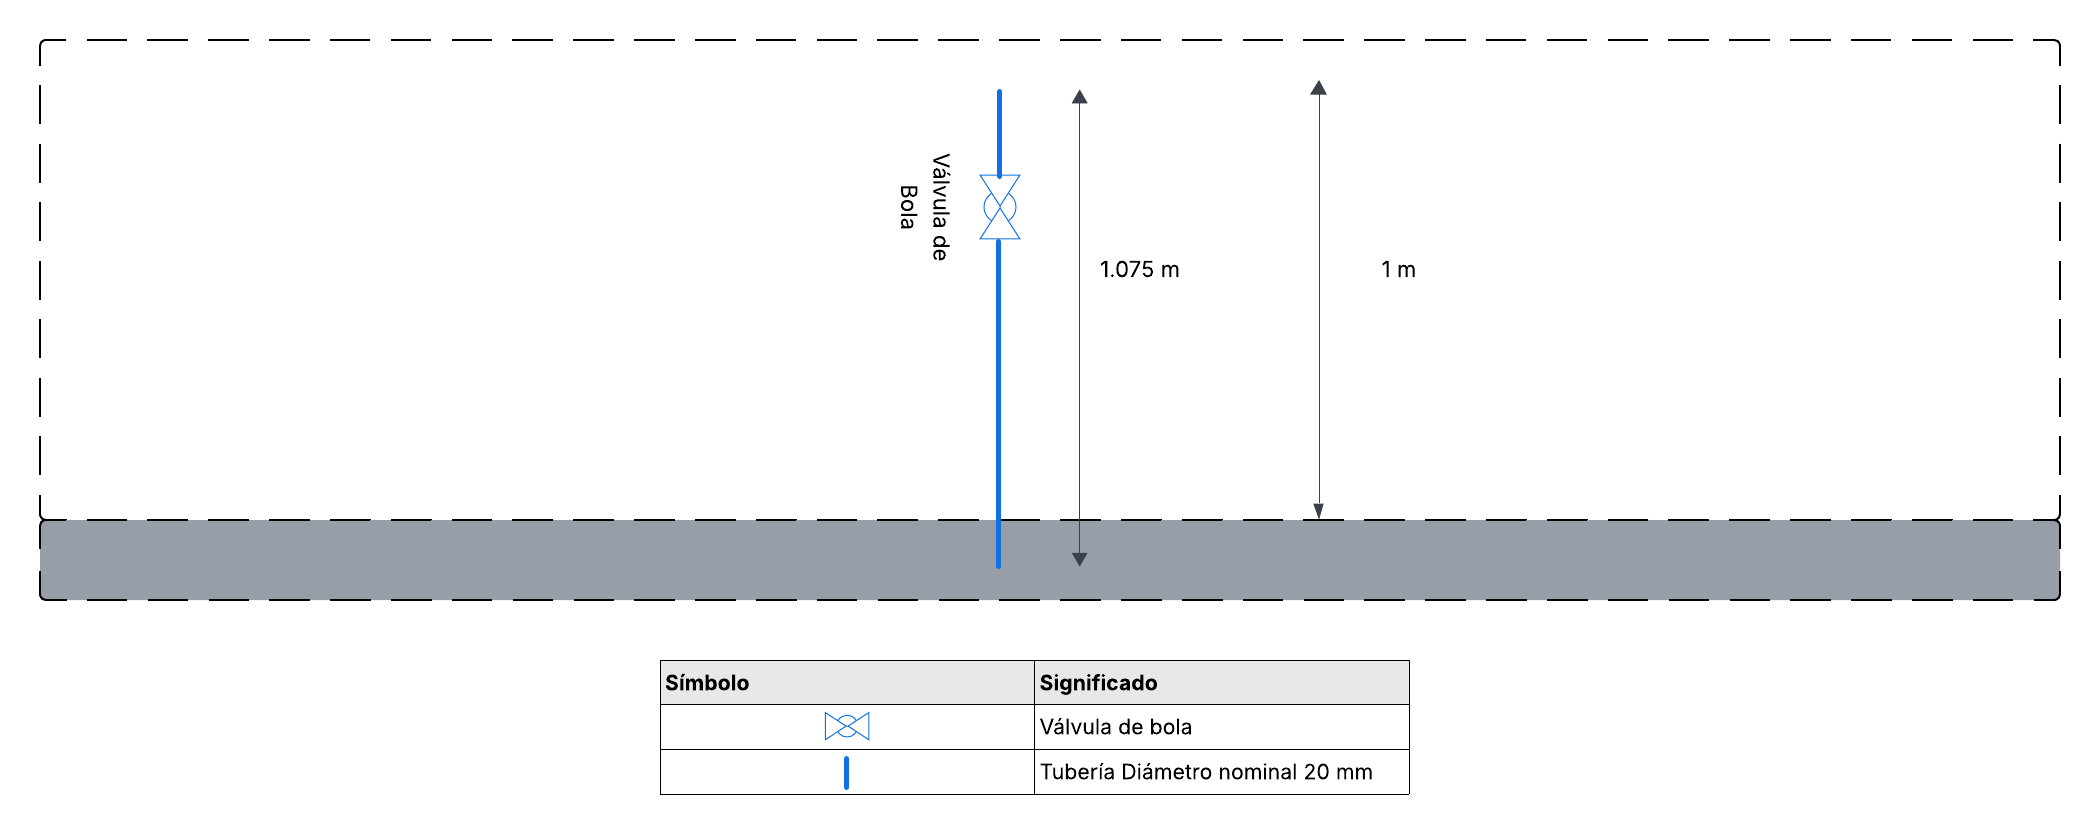

In [129]:
class Dispositivos:
    def __init__(self, inlet_pressure,
                 caudal_izq = 12 /(1000*60),   # lavaplatos
                 caudal_abajo = 8 / (1000*60), # lavamanos
                 caudal_der = 10 / (1000*60),   # ducha
                 diametro_interno = diametro_horizontal_interno,
                 diametro_nominal = diametro_horizontal_nominal,
                 rugosidad= rugosidad_ppr):

        self.inlet_pressure = inlet_pressure
        self.Q_izq = caudal_izq
        self.Q_abajo = caudal_abajo
        self.Q_der = caudal_der

        self.Q_derecha_total = self.Q_abajo + self.Q_der
        self.Q_total = self.Q_izq + self.Q_derecha_total


        self.D = diametro_interno
        self.D_nominal = diametro_nominal
        self.rugosidad_relativa = rugosidad / self.D

        self.density = CP.PropsSI('D', 'P', self.inlet_pressure, 'T', 60 + 273.15, 'water')
        self.viscosity = CP.PropsSI('VISCOSITY', 'P', self.inlet_pressure, 'T', 60 + 273.15, 'water')
        # print(f"Densidad: {self.density:.3f} kg/m3\n Viscosidad: {self.viscosity*1e3:.3f}e-3 Pa.s")

        self.presion_final_1 = self.inlet_pressure - self.caida_dispositivo_1()
        self.presion_final_2 = self.inlet_pressure - self.caida_dispositivo_2()
        self.presion_final_3 = self.inlet_pressure - self.caida_dispositivo_3()

        self.velocidad_1 = velocity_function(self.Q_izq, self.D)
        # print(f"Velocidad con la que llega al dispositivo 1: {self.velocidad_1:.3f} m/s")
        self.velocidad_2 = velocity_function(self.Q_abajo, self.D)
        # print(f"Velocidad con la que llega al dispositivo 2: {self.velocidad_2:.3f} m/s")
        self.velocidad_3 = velocity_function(self.Q_der, self.D)
        # print(f"Velocidad con la que llega al dispositivo 3: {self.velocidad_3:.3f} m/s")

        self.velocidad_total = velocity_function(self.Q_total, self.D)
        # print(f"Velocidad con la que entra al departamento: {self.velocidad_total:.3f} m/s")
        # print(self.velocidad_1, self.velocidad_2, self.velocidad_3)

    def salida_dispositivo(self, velocidad):
        reynolds = reynolds_number(velocidad, self.D, self.density, self.viscosity)
        f = swamee_jain(reynolds, self.rugosidad_relativa)
        friction_loss = friction_pressure_losses(f=f, length=1.075, diameter=self.D, density=self.density, velocity=velocidad)
        k_valve = method_3k(Reynolds=reynolds, nominal_diameter=self.D_nominal, fitting_type="Valve, ball")
        valve_losses = singularity_pressure_losses(velocidad, self.density, k_valve)
        return friction_loss + valve_losses

    def caida_dispositivo_1(self):
        # Pérdidas con el caudal total en un tramo de 2 metros de largo
        main_velocity = velocity_function(self.Q_total, self.D)
        main_reynolds = reynolds_number(main_velocity, self.D, self.density, self.viscosity)
        f_1 = swamee_jain(main_reynolds, self.rugosidad_relativa)
        loss_1 = friction_pressure_losses(f=f_1, length=2, diameter=self.D, density=self.density, velocity=main_velocity)

        # Pérdida por el branch tipo run
        Q_run = self.Q_izq
        Q_branch = self.Q_abajo + self.Q_der
        K_run = K_diverging_fitting("run", Qbranch=Q_branch, Qcombined=self.Q_total, Dbranch=self.D, Dcombined=self.D, alpha=90)
        branch_losses = singularity_pressure_losses(main_velocity, self.density, K_run)

        # Pérdidas con el caudal de la izquierda en un tramo de 2 + 4.5 m:
        velocity = velocity_function(self.Q_izq, self.D)
        reynolds = reynolds_number(velocity, self.D, self.density, self.viscosity)
        f_2 = swamee_jain(reynolds, self.rugosidad_relativa)
        loss_2 = friction_pressure_losses(f=f_2, length=6.5, diameter=self.D, density=self.density, velocity=velocity)

        # Agregar pérdidas por el codo

        # Calcular las pérdidas totales y printear los resultados

        total_losses = loss_1 + branch_losses + loss_2 + self.salida_dispositivo(velocity)

        return total_losses

    def caida_dispositivo_2(self):
        # Pérdidas con el caudal total en un tramo de 2 metros de largo
        main_velocity = velocity_function(self.Q_total, self.D)
        main_reynolds = reynolds_number(main_velocity, self.D, self.density, self.viscosity)
        f_1 = swamee_jain(main_reynolds, self.rugosidad_relativa)
        loss_1 = friction_pressure_losses(f=f_1, length=2, diameter=self.D, density=self.density, velocity=main_velocity)

        # Pérdida por el branch
        Q_run = self.Q_izq
        Q_branch = self.Q_abajo + self.Q_der
        K_run = K_diverging_fitting("branch", Qbranch=Q_branch, Qcombined=self.Q_total, Dbranch=self.D, Dcombined=self.D, alpha=90)
        branch_losses = singularity_pressure_losses(main_velocity, self.density, K_run)

        # Pérdidas con el caudal de la derecha + el de abajo en un tramo de 1 metro
        velocity = velocity_function(self.Q_abajo + self.Q_der, self.D)
        reynolds = reynolds_number(velocity, self.D, self.density, self.viscosity)
        f_2 = swamee_jain(reynolds, self.rugosidad_relativa)
        loss_2 = friction_pressure_losses(f=f_2, length=1, diameter=self.D, density=self.density, velocity=velocity)

        # Pérdidas en el branch de la derecha
        Q_run = self.Q_der
        Q_branch = self.Q_abajo
        K_run = K_diverging_fitting("branch", Qbranch=Q_branch, Qcombined=Q_run +Q_branch, Dbranch=self.D, Dcombined=self.D, alpha=90)
        second_branch_losses = singularity_pressure_losses(velocity, self.density, K_run)

        # Pérdidas en el tramo de 0.5 m con un caudal de Q_abajo
        velocity_abajo = velocity_function(self.Q_abajo, self.D)
        reynolds_abajo = reynolds_number(velocity_abajo, self.D, self.density, self.viscosity)
        f_3 = swamee_jain(reynolds_abajo, self.rugosidad_relativa)
        loss_3 = friction_pressure_losses(f=f_3, length=0.5, diameter=self.D, density=self.density, velocity=velocity_abajo)

        total_losses = loss_1 + loss_2 + loss_3 + branch_losses + second_branch_losses + self.salida_dispositivo(velocity_abajo)

        return total_losses

    def caida_dispositivo_3(self):
        # Pérdidas con el caudal total en un tramo de 2 metros de largo
        main_velocity = velocity_function(self.Q_total, self.D)
        main_reynolds = reynolds_number(main_velocity, self.D, self.density, self.viscosity)
        f_1 = swamee_jain(main_reynolds, self.rugosidad_relativa)
        loss_1 = friction_pressure_losses(f=f_1, length=2, diameter=self.D, density=self.density, velocity=main_velocity)

        # Pérdida por el branch
        Q_run = self.Q_izq
        Q_branch = self.Q_abajo + self.Q_der
        K_run = K_diverging_fitting("branch", Qbranch=Q_branch, Qcombined=self.Q_total, Dbranch=self.D, Dcombined=self.D, alpha=90)
        branch_losses = singularity_pressure_losses(main_velocity, self.density, K_run)

        # Pérdidas con el caudal de la derecha + el de abajo en un tramo de 1 metro
        velocity = velocity_function(self.Q_abajo + self.Q_der, self.D)
        reynolds = reynolds_number(velocity, self.D, self.density, self.viscosity)
        f_2 = swamee_jain(reynolds, self.rugosidad_relativa)
        loss_2 = friction_pressure_losses(f=f_2, length=1, diameter=self.D, density=self.density, velocity=velocity)

        # Pérdidas en el branch de la derecha
        Q_run = self.Q_der
        Q_branch = self.Q_abajo
        K_run = K_diverging_fitting("run", Qbranch=Q_branch, Qcombined=Q_run + Q_branch, Dbranch=self.D, Dcombined=self.D, alpha=90)
        second_branch_losses = singularity_pressure_losses(velocity, self.density, K_run)

        # Pérdidas en el tramo de 0.5 m con un caudal de Q_abajo
        velocity_derecha = velocity_function(self.Q_der, self.D)
        reynolds_derecha = reynolds_number(velocity_derecha, self.D, self.density, self.viscosity)
        f_3 = swamee_jain(reynolds_derecha, self.rugosidad_relativa)
        loss_3 = friction_pressure_losses(f=f_3, length=1, diameter=self.D, density=self.density, velocity=velocity_derecha)

        total_losses = loss_1 + loss_2 + loss_3 + branch_losses + second_branch_losses + self.salida_dispositivo(velocity_derecha)

        return total_losses

### Clase Departamento

Calcula la pérdida dentro de cada piso y la presión de entrada a cada departamento. Recibe como parámetro la presión que ingresa al piso

![Salida del departamento.png](<attachment:Salida del departamento.png>)
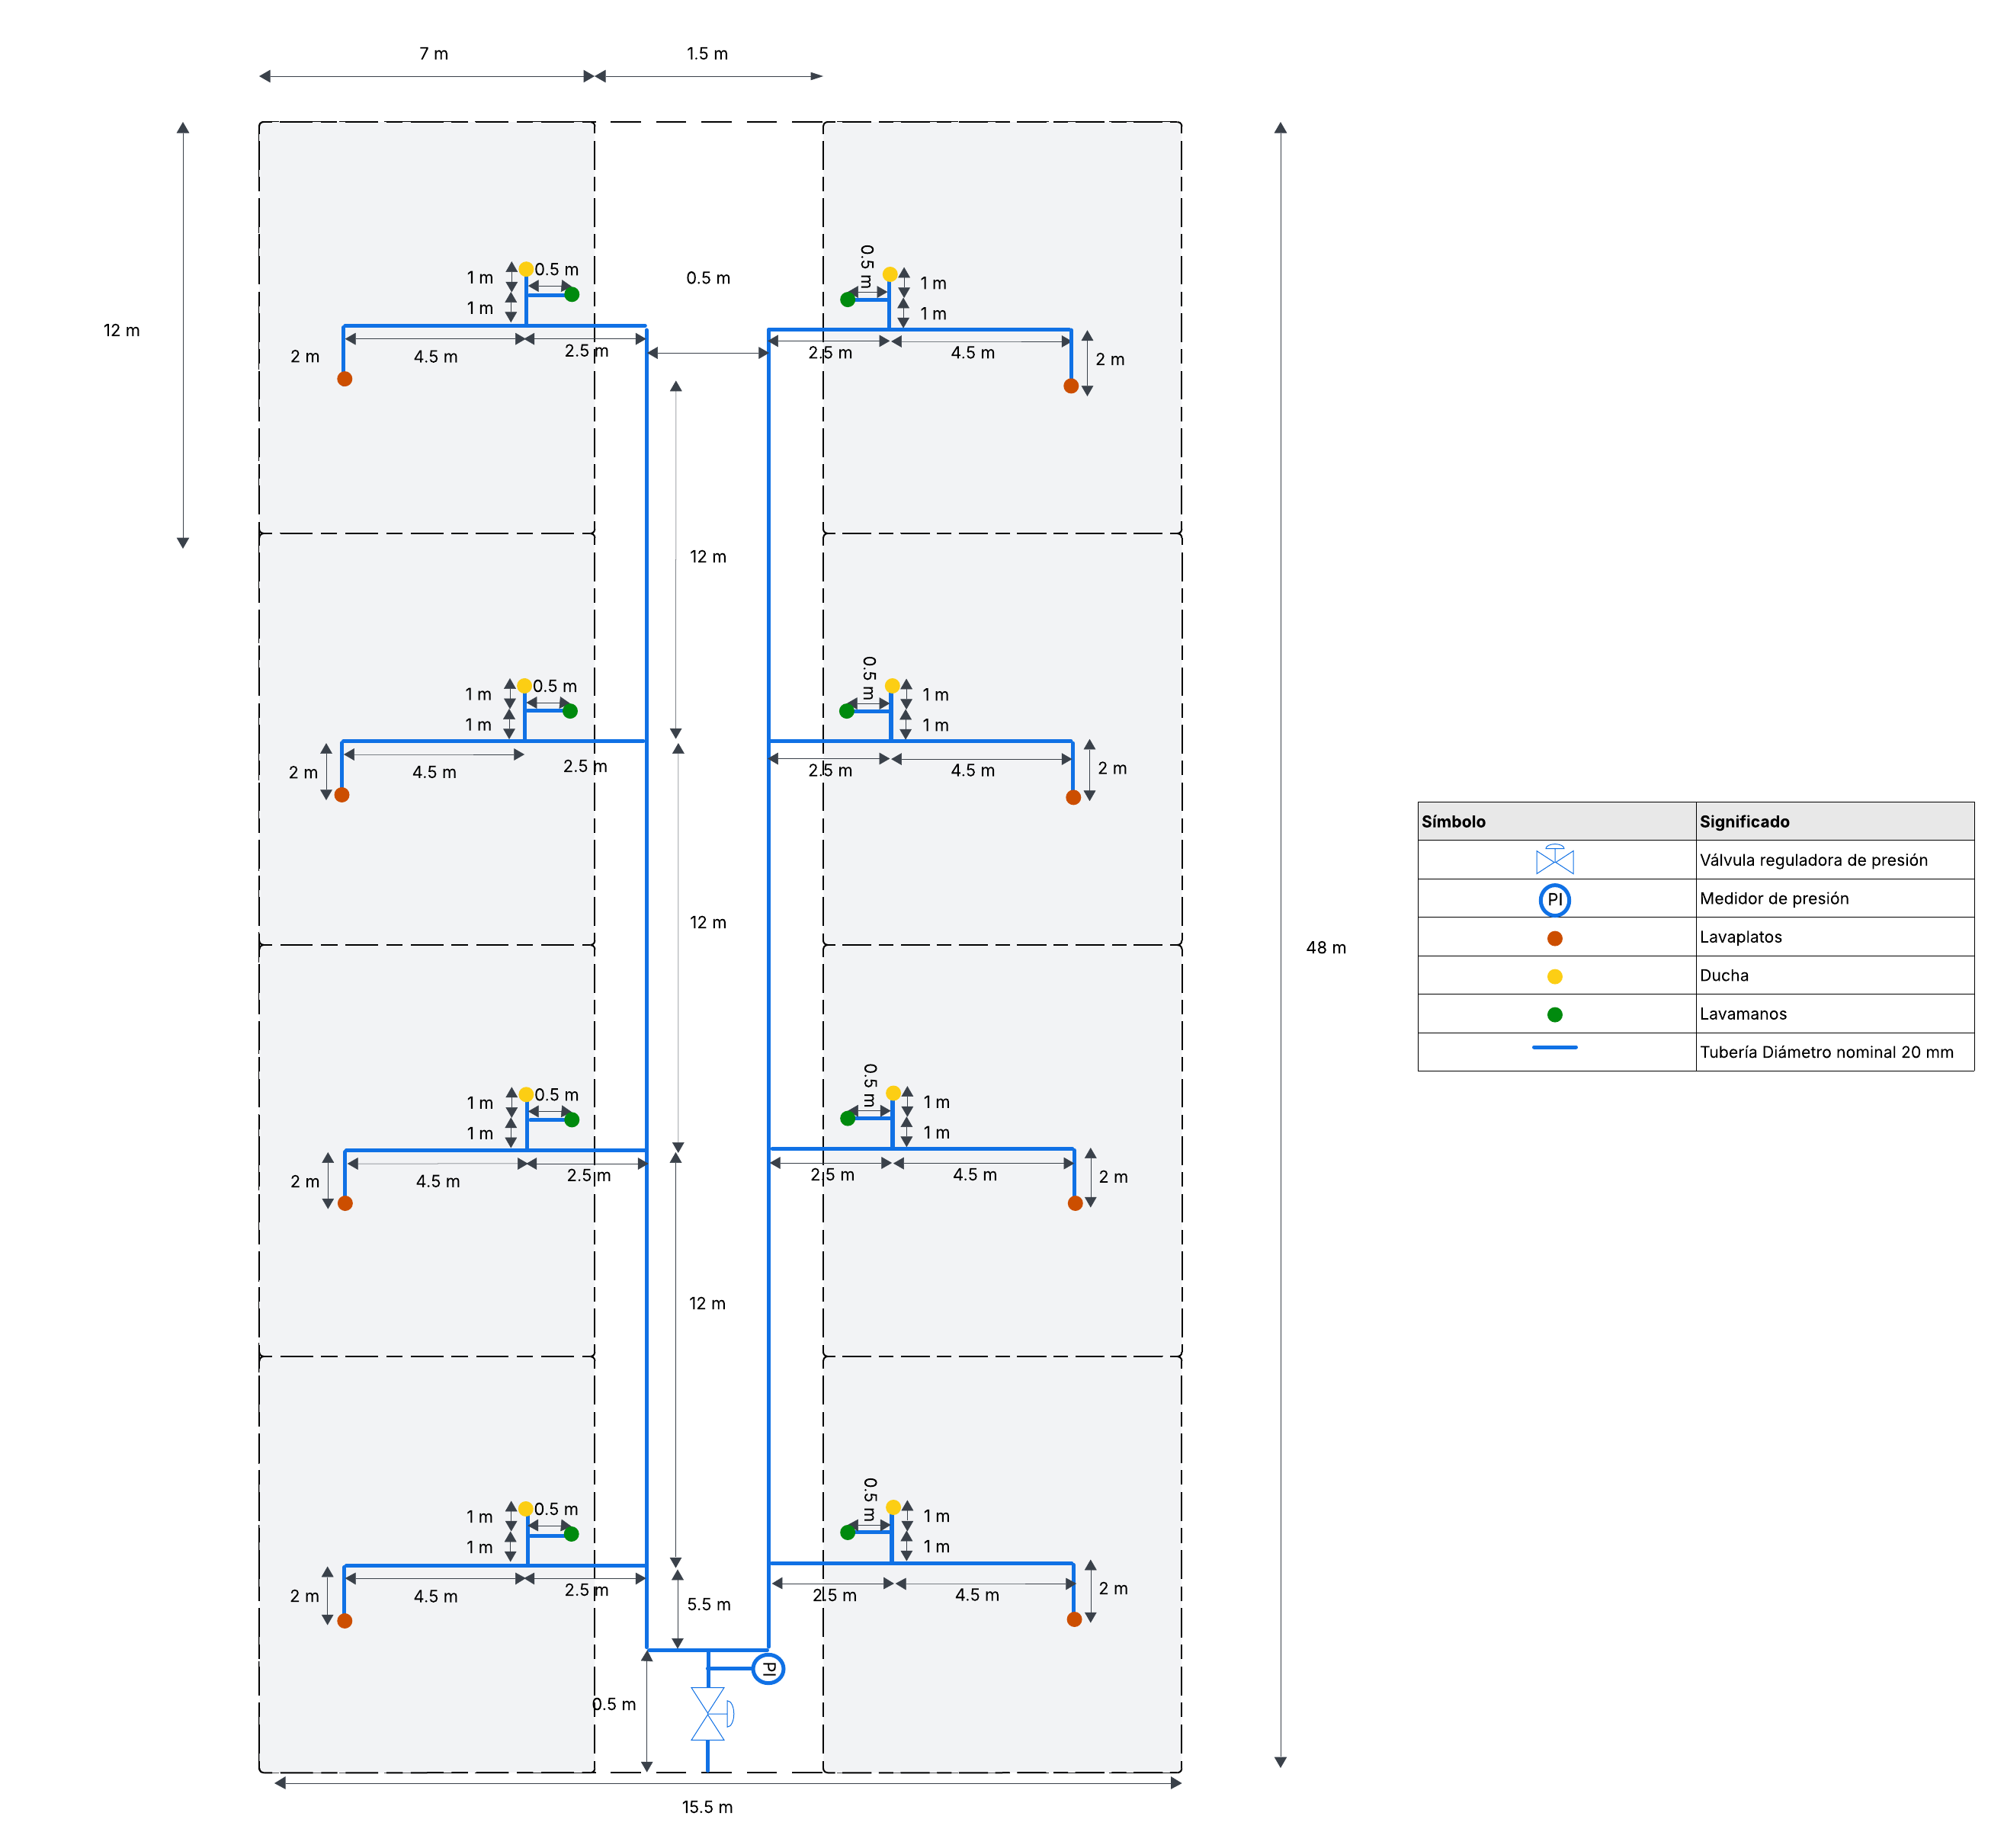

In [130]:
class Departamento:
    def __init__(self, inlet_pressure, # La presión inicial es la presión de entrada al depto
                 numero_departamento,
                 caudal_planta = caudal_sin_factor / 10, # El del edificio dividido el número de pisos
                 diametro_horizontal = diametro_piso_interno,
                 diametro_nominal = diametro_piso_nominal,
                 diametro_depto = diametro_horizontal_interno,
                 diametro_depto_nominal = diametro_horizontal_nominal,
                 rugosidad = rugosidad_ppr): 

        self.numero_dpto = numero_departamento
        self.caudal_total = caudal_planta
        self.diametro_horizontal = diametro_horizontal
        self.diametro_horizontal_nominal = diametro_nominal
        self.diametro_depto = diametro_depto
        self.diametro_depto_nominal = diametro_depto_nominal
        self.rugosidad_relativa = rugosidad / self.diametro_horizontal

        self.inlet_pressure = inlet_pressure
        self.density = CP.PropsSI('D', 'P', self.inlet_pressure, 'T', 60 + 273.15, 'water')
        self.viscosity = CP.PropsSI('VISCOSITY', 'P', self.inlet_pressure, 'T', 60 + 273.15, 'water')

        self.caida_presion = self.perdidas()
        # print(f"Caída de presión por llegar al departamento {self.numero_dpto}: {self.caida_presion} Pa\n")
        self.presion_final = self.inlet_pressure - self.caida_presion

        self.velocidad = velocity_function(self.caudal_total, self.diametro_horizontal)
        # print(f"Velocidad con la que el agua entra al piso: {self.velocidad:.3f} m/s")

    def perdidas_depto_1_y_5(self):
        # Pérdidas en el tramo de 0,5 m con el caudal del piso
        velocity = velocity_function(self.caudal_total, self.diametro_horizontal)
        reynolds = reynolds_number(velocity, self.diametro_horizontal, self.density, self.viscosity)
        f = swamee_jain(reynolds, self.rugosidad_relativa)
        friction_losses = friction_pressure_losses(f, 0.5, self.diametro_horizontal, self.density, velocity)    

        # Pérdidas en el branch
        K_branch = K_diverging_fitting("branch", Qbranch=self.caudal_total/2, Qcombined=self.caudal_total, Dbranch=self.diametro_horizontal, Dcombined=self.diametro_horizontal, alpha=90)
        branch_1_losses = singularity_pressure_losses(velocity, self.density, K_branch)

        # Pérdidas en el tramo de 0.25 + 5.5 m
        velocity_branch = velocity_function(self.caudal_total/2, self.diametro_horizontal)
        reynolds_branch = reynolds_number(velocity_branch, self.diametro_horizontal, self.density, self.viscosity)
        f_branch = swamee_jain(reynolds_branch, self.rugosidad_relativa)
        second_friction_losses = friction_pressure_losses(f_branch, 5.75, self.diametro_horizontal, self.density, velocity_branch)

        # Ahora calcular las pérdidas en este tramo
        Q_combined = self.caudal_total * (4/8) # Del caudal que entra se debe dividir en 3 deptos
        velocity_combined = velocity_function(Q_combined, self.diametro_horizontal)
        Q_branch = self.caudal_total * (1/8)

        if self.numero_dpto == 1 or self.numero_dpto == 5:
            # Tengo que calcular pérdidas en el branch y pérdidas en el tramo de 0.5 m

            # Pérdidas en el branch
            K_branch = K_diverging_fitting("branch", Qbranch=Q_branch, Qcombined=Q_combined, Dbranch=self.diametro_depto, Dcombined=self.diametro_horizontal, alpha=90)
            branch_2_losses = singularity_pressure_losses(velocity_combined, self.density, K_branch)

            # Pérdidas en el tramo de 0.5 m
            velocity = velocity_function(Q_branch, self.diametro_depto)
            reynolds = reynolds_number(velocity, self.diametro_depto, self.density, self.viscosity)
            f = swamee_jain(reynolds, self.rugosidad_relativa)
            second_losses = friction_pressure_losses(f, 0.5, self.diametro_depto, self.density, velocity)

            perdidas = branch_1_losses + friction_losses + second_friction_losses + branch_2_losses + second_losses

        else:
            # Entonces sólo me interesan las pérdidas en el tramo de 12 m y en el run
            
            perdidas = second_friction_losses + branch_1_losses + friction_losses

        return perdidas

    def perdidas_depto_2_y_6(self):
        perdidas_iniciales = self.perdidas_depto_1_y_5()

        # Ahora calcular las pérdidas en este tramo
        Q_combined = self.caudal_total * (3/8) # Del caudal que entra se debe dividir en 3 deptos
        Q_branch = self.caudal_total * (1/8)

        # Pérdidas en el run del depto anterior

        # En este caso el Q_combined es el caudal total que llega al depto 1
        K_run = K_diverging_fitting("run", Qbranch=Q_branch, Qcombined=Q_combined + Q_branch, Dbranch=self.diametro_depto, Dcombined=self.diametro_horizontal, alpha=90)
        velocity_before = velocity_function(Q_combined + Q_branch, self.diametro_horizontal)
        run_losses = singularity_pressure_losses(velocity_before, self.density, K_run)

        # Pérdidas por fricción en el tramo de 12 m
        velocity_combined = velocity_function(Q_combined, self.diametro_horizontal)
        reynolds_combined = reynolds_number(velocity_combined, self.diametro_horizontal, self.density, self.viscosity)
        f_combined = swamee_jain(reynolds_combined, self.rugosidad_relativa)
        friction_losses = friction_pressure_losses(f_combined, 12, self.diametro_horizontal, self.density, velocity_combined)

        if self.numero_dpto == 2 or self.numero_dpto == 6:
            # Tengo que calcular pérdidas en el branch y pérdidas en el tramo de 0.5 m

            # Pérdidas en el branch
            K_branch = K_diverging_fitting("branch", Qbranch=Q_branch, Qcombined=Q_combined, Dbranch=self.diametro_depto, Dcombined=self.diametro_horizontal, alpha=90)
            branch_losses = singularity_pressure_losses(velocity_combined, self.density, K_branch)

            # Pérdidas en el tramo de 0.5 m
            velocity = velocity_function(Q_branch, self.diametro_depto)
            reynolds = reynolds_number(velocity, self.diametro_depto, self.density, self.viscosity)
            f = swamee_jain(reynolds, self.rugosidad_relativa)
            second_losses = friction_pressure_losses(f, 0.5, self.diametro_depto, self.density, velocity)

            perdidas = perdidas_iniciales + run_losses + friction_losses + branch_losses + second_losses

        else:
            # Entonces sólo me interesan las pérdidas en el tramo de 12 m y en el run
            
            perdidas = perdidas_iniciales + run_losses + friction_losses

        return perdidas

    def perdidas_depto_3_y_7(self):
        perdidas_iniciales = self.perdidas_depto_2_y_6()

        # Ahora calcular las pérdidas en este tramo
        Q_combined = self.caudal_total * (2/8) # Del caudal que entra se debe dividir en 3 deptos
        Q_branch = self.caudal_total * (1/8)

        # Pérdidas en el run del depto anterior
        # En este caso el Q_combined es el caudal total que llega al depto 1
        K_run = K_diverging_fitting("run", Qbranch=Q_branch, Qcombined=Q_combined + Q_branch, Dbranch=self.diametro_depto, Dcombined=self.diametro_horizontal, alpha=90)
        velocity_before = velocity_function(Q_combined + Q_branch, self.diametro_horizontal)
        run_losses = singularity_pressure_losses(velocity_before, self.density, K_run)

        # Pérdidas por fricción en el tramo de 12 m
        velocity_combined = velocity_function(Q_combined, self.diametro_horizontal)
        reynolds_combined = reynolds_number(velocity_combined, self.diametro_horizontal, self.density, self.viscosity)
        f_combined = swamee_jain(reynolds_combined, self.rugosidad_relativa)
        friction_losses = friction_pressure_losses(f_combined, 12, self.diametro_horizontal, self.density, velocity_combined)

        if self.numero_dpto == 3 or self.numero_dpto == 7:
            # Tengo que calcular pérdidas en el branch y pérdidas en el tramo de 0.5 m

            # Pérdidas en el branch
            K_branch = K_diverging_fitting("branch", Qbranch=Q_branch, Qcombined=Q_combined, Dbranch=self.diametro_depto, Dcombined=self.diametro_horizontal, alpha=90)
            branch_losses = singularity_pressure_losses(velocity_combined, self.density, K_branch)

            # Pérdidas en el tramo de 0.5 m
            velocity = velocity_function(Q_branch, self.diametro_depto)
            reynolds = reynolds_number(velocity, self.diametro_depto, self.density, self.viscosity)
            f = swamee_jain(reynolds, self.rugosidad_relativa)
            second_losses = friction_pressure_losses(f, 0.5, self.diametro_depto, self.density, velocity)

            perdidas = perdidas_iniciales + run_losses + friction_losses + branch_losses + second_losses

        else:
            # Entonces sólo me interesan las pérdidas en el tramo de 12 m y en el run
            
            perdidas = perdidas_iniciales + run_losses + friction_losses
        
        return perdidas

    def perdidas_depto_4_y_8(self):
        perdidas_iniciales = self.perdidas_depto_3_y_7()

        # Ahora calcular las pérdidas en este tramo
        Q_combined = self.caudal_total * (1/8) # Del caudal que entra se debe dividir en 3 deptos
        Q_branch = self.caudal_total * (1/8)

        # Pérdidas en el run del depto anterior
        # En este caso el Q_combined es el caudal total que llega al depto 1
        K_run = K_diverging_fitting("run", Qbranch=Q_branch, Qcombined=Q_combined + Q_branch, Dbranch=self.diametro_depto, Dcombined=self.diametro_horizontal, alpha=90)
        velocity_before = velocity_function(Q_combined + Q_branch, self.diametro_horizontal)
        run_losses = singularity_pressure_losses(velocity_before, self.density, K_run)

        # Pérdidas por fricción en el tramo de 12 m
        velocity_combined = velocity_function(Q_combined, self.diametro_horizontal)
        reynolds_combined = reynolds_number(velocity_combined, self.diametro_horizontal, self.density, self.viscosity)
        f_combined = swamee_jain(reynolds_combined, self.rugosidad_relativa)
        friction_losses = friction_pressure_losses(f_combined, 12, self.diametro_horizontal, self.density, velocity_combined)

        # Pérdidas en el codo
        velocity = velocity_function(Q_branch, self.diametro_depto)
        reynolds = reynolds_number(velocity, self.diametro_depto, self.density, self.viscosity)

        K_elbow = method_3k(Reynolds=reynolds, nominal_diameter=self.diametro_depto_nominal, fitting_type="90° elbow, standard, threaded")
        elbow_losses = singularity_pressure_losses(velocity_combined, self.density, K_elbow)

        # Pérdidas en el tramo de 0.5 m
        f = swamee_jain(reynolds, self.rugosidad_relativa)
        second_losses = friction_pressure_losses(f, 0.5, self.diametro_depto, self.density, velocity)

        perdidas = perdidas_iniciales + run_losses + friction_losses + elbow_losses + second_losses
        return perdidas
    
    def perdidas(self):
        if self.numero_dpto == 1 or self.numero_dpto == 5:
            return self.perdidas_depto_1_y_5()
        
        if self.numero_dpto == 2 or self.numero_dpto == 6:
            return self.perdidas_depto_2_y_6()
        
        if self.numero_dpto == 3 or self.numero_dpto == 7:
            return self.perdidas_depto_3_y_7()
        
        if self.numero_dpto == 4 or self.numero_dpto == 8:
            return self.perdidas_depto_4_y_8()
    
        

### Clase Piso:

Calcula las pérdidas de presión al subir entre los pisos y la presión a la entrada de cada piso. Recibe como parámetro la presión a la salida de la bomba

![Piping Proyecto Termofluidos-2.png](<attachment:Piping Proyecto Termofluidos-2.png>)
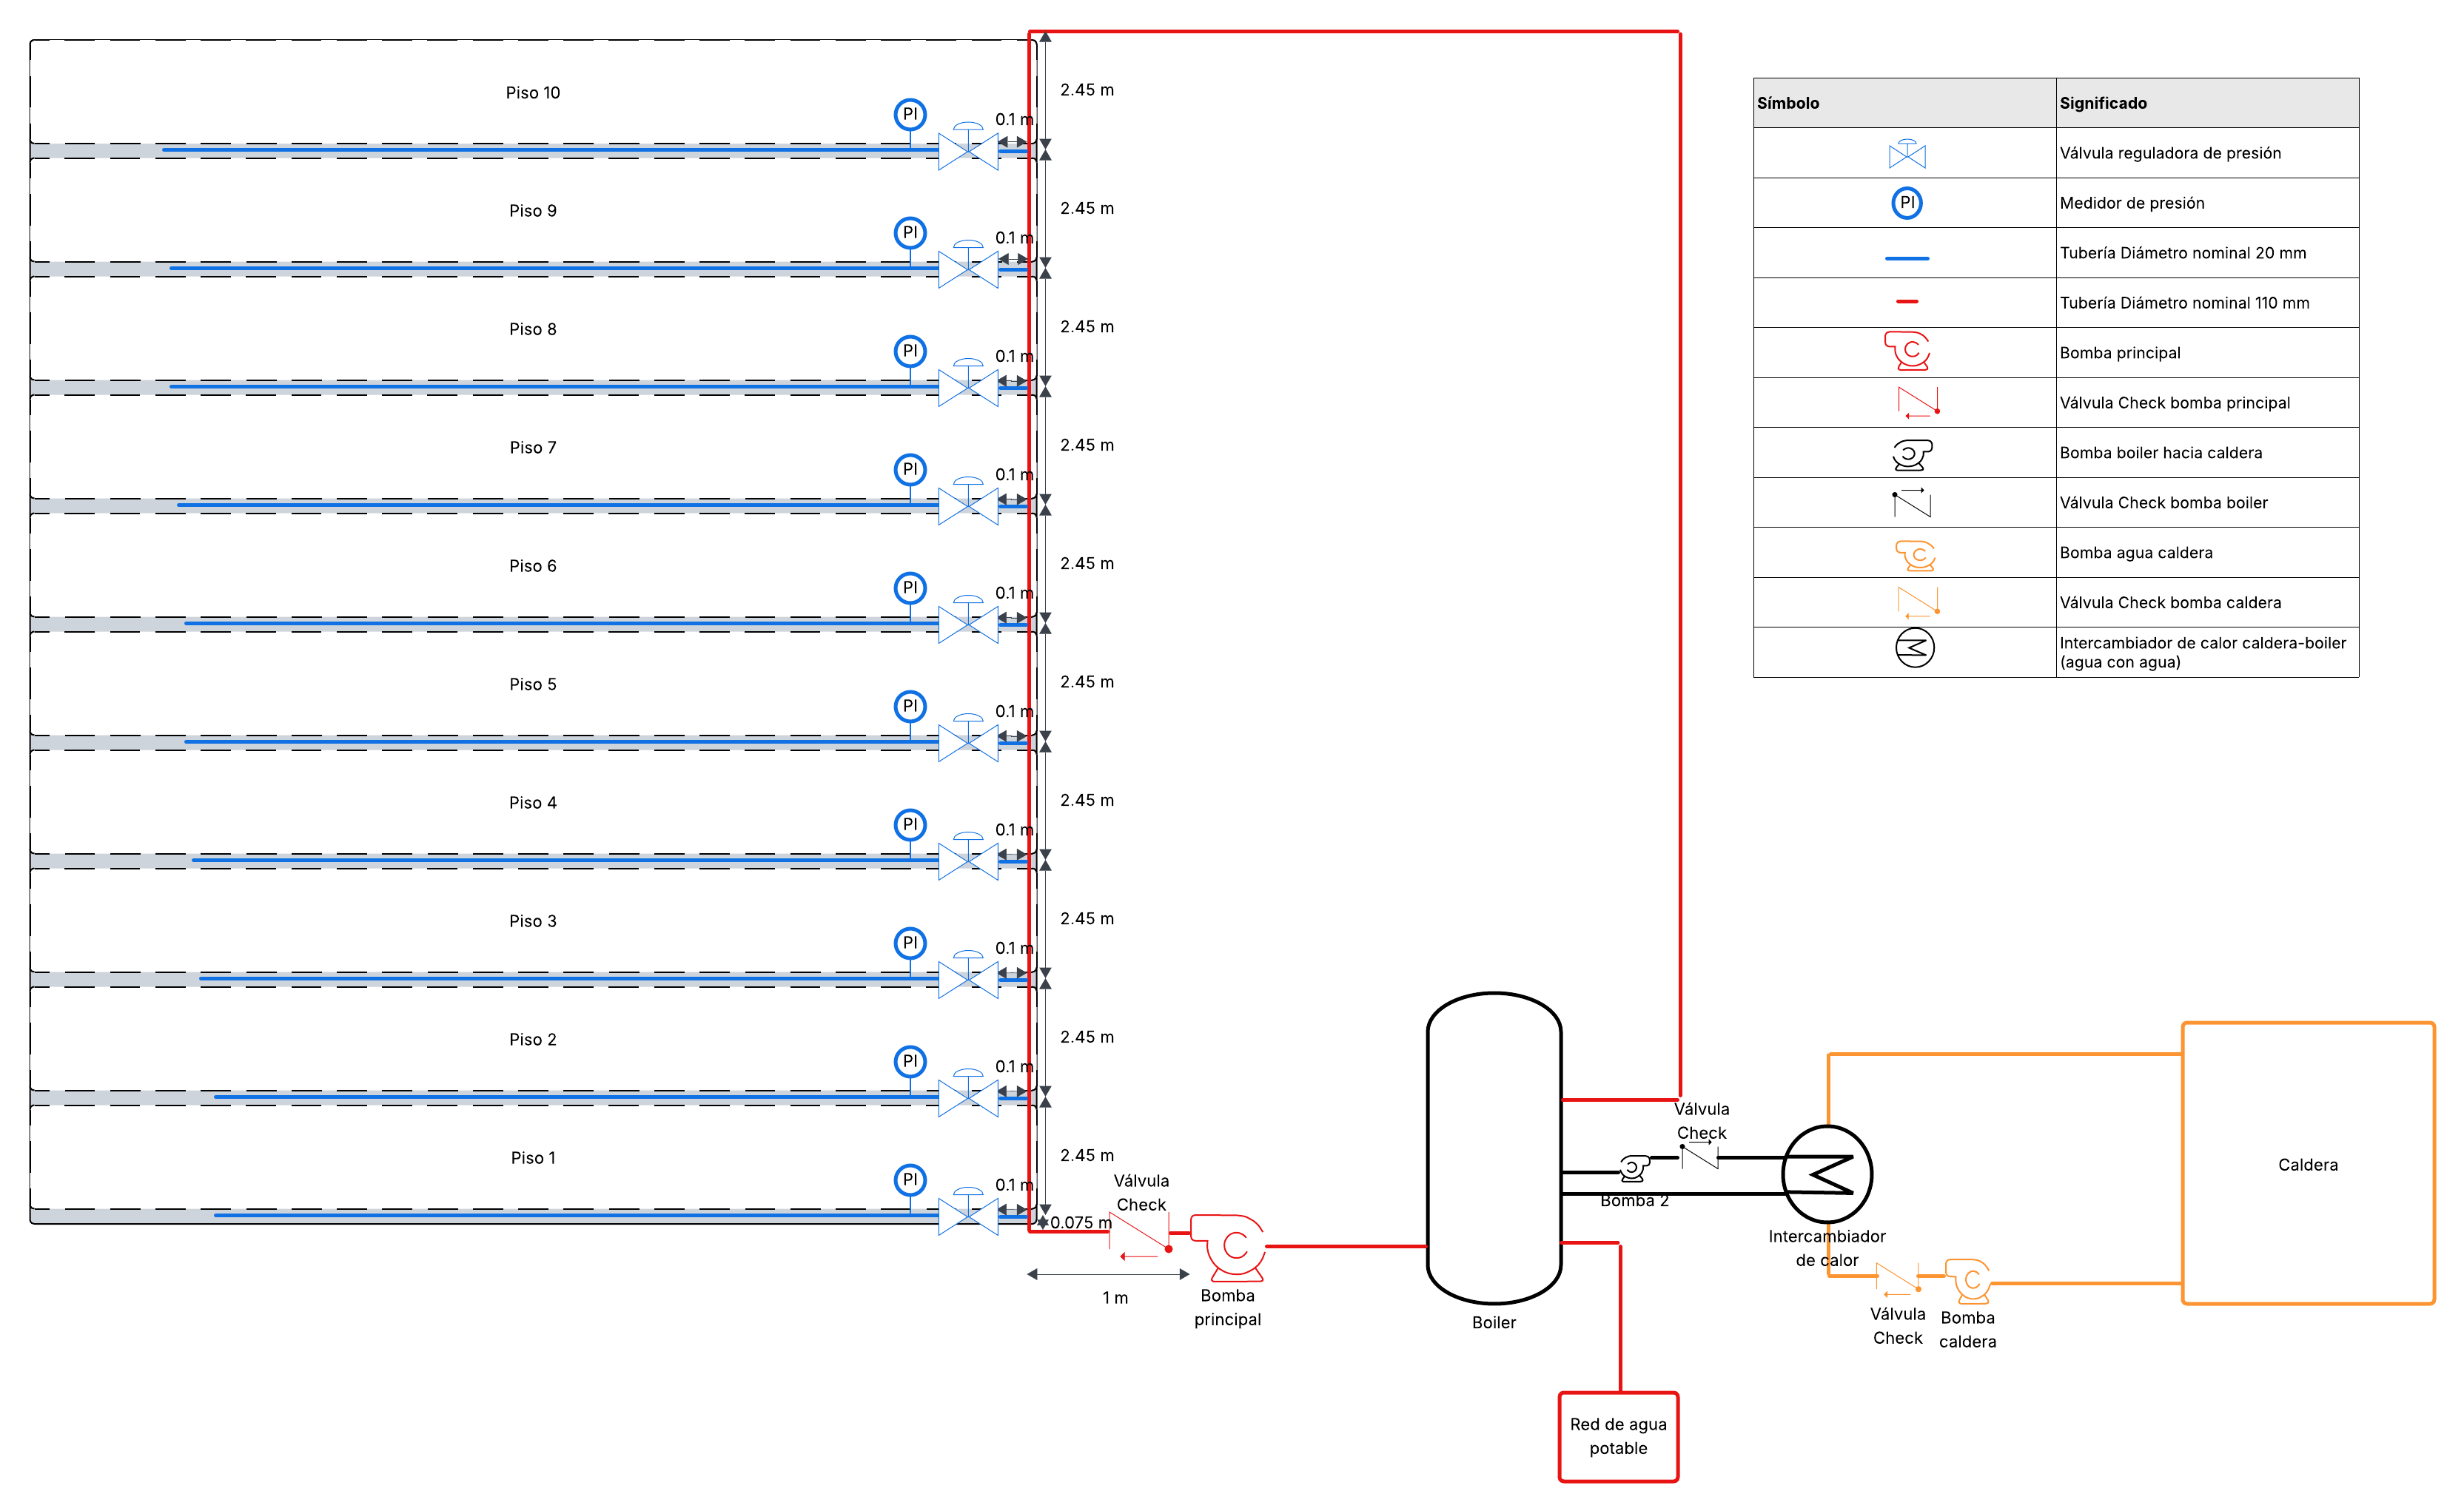

In [131]:
class Piso:
    def __init__(self, inlet_pressure, # La presión inicial es la presión a la salida de la bomba
                 numero_piso,
                 caudal_total = caudal_sin_factor, # El caudal total debe ser conocido
                 diametro_veritcal = diametro_vertical_interno,
                 diametro_vertical_nominal = diametro_vertical_nominal,
                 diametro_horizontal = diametro_horizontal_interno,
                 diametro_horizontal_nominal = diametro_horizontal_nominal,
                 rugosidad = rugosidad_ppr): 


        self.numero_piso = numero_piso
        self.caudal_total = caudal_total
        self.diametro_vertical = diametro_veritcal
        self.diametro_vertical_nominal = diametro_vertical_nominal
        self.diametro_horizontal = diametro_horizontal
        self.diametro_horizontal_nominal = diametro_horizontal_nominal
        self.rugosidad_relativa_vertical = rugosidad / self.diametro_vertical
        self.rugosidad_relativa_horizontal = rugosidad / self.diametro_horizontal

        self.inlet_pressure = inlet_pressure
        self.density = CP.PropsSI('D', 'P', self.inlet_pressure, 'T', 60 + 273.15, 'water')
        self.viscosity = CP.PropsSI('VISCOSITY', 'P', self.inlet_pressure, 'T', 60 + 273.15, 'water')
        # print(f"Densidad: {self.density:.3f} kg/m3\n Viscosidad: {self.viscosity*1e3:.3f}e-3 Pa.s")

        self.velocidad_bomba = velocity_function(self.caudal_total, self.diametro_vertical)
        self.velocidad_piso_i = velocity_function(self.caudal_total, self.diametro_vertical)
        
        self.caida_presion = self.perdidas_piso_i()
        # print(f"Pérdidas de presión hasta llegar al piso {self.numero_piso}: {self.caida_presion:.2f} Pa\n")
        self.presion_final = self.inlet_pressure - self.caida_presion


    def perdidas_hasta_piso_1(self):
        total_losses = 0
        # Pérdidas por fricción en un tramo de 1.075 m
        velocity = velocity_function(self.caudal_total, self.diametro_vertical)
        reynolds = reynolds_number(velocity=velocity, diameter=self.diametro_vertical, density=self.density, viscosity=self.viscosity)
        f = swamee_jain(reynolds, self.rugosidad_relativa_vertical)
        friction_losses = friction_pressure_losses(f, 1.075, self.diametro_vertical, self.density, velocity)
        total_losses += friction_losses

        K_elbow = method_3k(Reynolds=reynolds, nominal_diameter=self.diametro_vertical_nominal, fitting_type="90° elbow, standard, threaded")
        elbow_losses = singularity_pressure_losses(velocity, self.density, K_elbow)
        total_losses += elbow_losses

        k_check = method_3k(Reynolds=reynolds, nominal_diameter=self.diametro_vertical_nominal, fitting_type="Valve, check, lift")
        check_valve_losses = singularity_pressure_losses(velocity, self.density, k_check)
        total_losses += check_valve_losses

        return total_losses

    def perdidas_piso_i(self):
        total_losses = self.perdidas_hasta_piso_1()
        # print(f"Pérdidas hasta el piso 1: {total_losses:.2f} Pa")
        Q_up = self.caudal_total
        # Falta incluir las pérdidas desde la bomba hasta la altura del primer piso (que todos los departamentos tienen la misma)
        for i in range(self.numero_piso):

            # Pérdida por fricción al subir (sólo si i > 0):
            if i > 0:
                velocity = velocity_function(Q_up, self.diametro_vertical)
                reynolds = reynolds_number(velocity=velocity, diameter=self.diametro_vertical, density=self.density, viscosity=self.viscosity)
                f = swamee_jain(reynolds, self.rugosidad_relativa_vertical)
                friction_losses = friction_pressure_losses(f, 2.45, self.diametro_vertical, self.density, velocity)
                # print(f"Piso Actual: {i + 1}, Pérdidas por fricción para llegar a este piso: {friction_losses:.2f} Pa")
                total_losses += friction_losses
                
            Q_branch = self.caudal_total / 10 # Caudal que se va a cada branch
            Q_up -= Q_branch # Caudal que sube del branch 
            before_velocity = velocity_function(Q_branch + Q_up, self.diametro_vertical)

            if i != self.numero_piso - 1:
                # El branch es de tipo run
                K_run = K_diverging_fitting("run", Qbranch=Q_branch, Qcombined=Q_up + Q_branch, Dbranch=self.diametro_horizontal, Dcombined=self.diametro_vertical, alpha=90)
                run_losses = singularity_pressure_losses(before_velocity, self.density, K_run)
                # print(f"Caudal combinado que llega al piso {i + 1}: {(Q_up + Q_branch)*1e3:.3f} L/s")
                # print(f"Pérdidas por el branch tipo run desde {i + 1} hacia arriba:: {run_losses:.2f} Pa\n")
                self.velocidad_piso_i  = velocity_function(Q_up, self.diametro_vertical) # Velocidad con la que llega al piso i
                total_losses += run_losses

            elif i == self.numero_piso - 1:
                # El branch es tipo branch
                K_branch = K_diverging_fitting("branch", Qbranch=Q_branch, Qcombined=Q_up + Q_branch, Dbranch=self.diametro_horizontal, Dcombined=self.diametro_vertical, alpha=90)
                branch_losses = singularity_pressure_losses(before_velocity, self.density, K_branch)

                # print(f"Caudal que entra al piso {i + 1}: {Q_branch*1e3:.3f} L/s")
                # print(f"Pérdidas por el branch tipo branch para entrar al piso {i + 1}: {branch_losses:.2f} Pa\n")
                total_losses += branch_losses

        
        return total_losses
    

### Clase Edificio

Recibe el número de piso y el número de departamento para poder mostrar de forma gráfica los resultados obtenidos.

Ecuación de Bernoulli entre un punto justo después de la bomba y la salida de un dispositivo:

\begin{equation*}
    \frac{P_1}{\gamma} + \frac{V_1^2}{2g} + z_1 = \frac{P_2}{\gamma} + \frac{V_2^2}{2g} + z_2 + h_L + h_S
\end{equation*}

\begin{equation*}
    P_2= \gamma \cdot (\frac{P_1}{\gamma} + \frac{V_1^2 - V_2^2}{2g} + (z_1 - z_2)) - \Delta P_{loss}
\end{equation*}

In [132]:
class Edificio:
    def __init__(self, numero_piso, # La presión inicial es la presión de entrada al depto
                 numero_departamento):


        self.numero_dpto = numero_departamento
        self.numero_piso = numero_piso
        self.presion_salida_bomba = 406052 # Cambiar


        self.piso = Piso(inlet_pressure=self.presion_salida_bomba, numero_piso=self.numero_piso)
        self.depa = Departamento(inlet_pressure=self.piso.presion_final, numero_departamento=self.numero_dpto)
        self.dispositivos = Dispositivos(inlet_pressure=self.depa.presion_final)

        self.presion_dispositivo_1, self.presion_dispositivo_2, self.presion_dispositivo_3 = self.bernoulli()

    def perdidas_totales(self):
        perdidas_totales_1 = self.piso.caida_presion + self.depa.caida_presion + self.dispositivos.caida_dispositivo_1()
        perdidas_totales_2 = self.piso.caida_presion + self.depa.caida_presion + self.dispositivos.caida_dispositivo_2()
        perdidas_totales_3 = self.piso.caida_presion + self.depa.caida_presion + self.dispositivos.caida_dispositivo_3()

        return perdidas_totales_1, perdidas_totales_2, perdidas_totales_3

    def bernoulli(self):
        presiones = []
        P1 = self.presion_salida_bomba # Pa
        gamma_1 = self.piso.density * 9.81 #
        V1 = self.piso.velocidad_bomba # m/s
        z1 = 0 # m
        gamma_2 = self.dispositivos.density * 9.81
        z2 = 0.075 + (2.45 * (self.numero_piso - 1)) + 1.075 # m


        # # imprimir los resultados en m.c.a
        # print(f"P1/gamma = {P1/gamma_1:.2f} mca")
        # print(f"V1^2/2g = {(V1 ** 2) / (2 * 9.81):.2f} mca")
        # print(f"z1 = {z1} mca")
        # print(f"z2 = {z2:.2f} mca")

        for i in range(3):
            losses = self.perdidas_totales()[i]
            # print(f"hl + hs = {losses/gamma_2:.2f} mca")
            if i == 0:
                V2 = self.dispositivos.velocidad_1
            elif i == 1:
                V2 = self.dispositivos.velocidad_2
            elif i == 2:
                V2 = self.dispositivos.velocidad_3
            # print(f"V2^2/2g = {(V2 ** 2) / (2 * 9.81):.2f} mca\n")
            
            # print(f"Velocidades para Bernoulli: {V1:.3f} m/s, {V2:.3f} m/s")
            P2 = gamma_2 * ((P1 / gamma_1) + (((V1 ** 2) - (V2 ** 2)) / (2 * 9.81)) + (z1 - z2)) - losses + presion_adicional

            presiones.append(P2)


        return presiones
        

headers = ["Número de piso", "Número de departamento", "Presión dispositivo 1", "Presión dispositivo 2", "Presión dispositivo 3"]
table = []
ploter_table = []

headers2 = ["Número de piso", "Número de departamento", "Delta Presión dispositivo 1", "Delta Presión dispositivo 2", "Delta Presión dispositivo 3"]
table2 = []

velocities_list = []
presion_minima_por_piso = []
for pisos in range(1, 11): # Son 10 pisos
    presiones_piso = []

    for departamentos in range(1, 9): # Son 8 departamentos por piso

        edificio = Edificio(numero_piso=pisos, numero_departamento=departamentos)
        # Agregar velocidades a la lista de velocidades presentes en el edificio
        velocities_list.append(edificio.piso.velocidad_bomba)
        velocities_list.append(edificio.piso.velocidad_piso_i)
        velocities_list.append(edificio.depa.velocidad)
        velocities_list.append(edificio.dispositivos.velocidad_1)
        velocities_list.append(edificio.dispositivos.velocidad_2)
        velocities_list.append(edificio.dispositivos.velocidad_3)
        velocities_list.append(edificio.dispositivos.velocidad_total)

        # ------------------------- Delta de presión de cada dispositivo -------------------------
        delta_presion_dispositivo_1 = edificio.presion_salida_bomba - edificio.presion_dispositivo_1
        delta_presion_dispositivo_2 = edificio.presion_salida_bomba - edificio.presion_dispositivo_2
        delta_presion_dispositivo_3 = edificio.presion_salida_bomba - edificio.presion_dispositivo_3

        # ------ Presión de salida de cada dispositivo -------
        presion_dispositivo_1 = edificio.presion_dispositivo_1
        presion_dispositivo_2 = edificio.presion_dispositivo_2
        presion_dispositivo_3 = edificio.presion_dispositivo_3

        presiones_piso.append(presion_dispositivo_1)
        presiones_piso.append(presion_dispositivo_2)
        presiones_piso.append(presion_dispositivo_3)

        table.append([pisos, departamentos, f"{presion_dispositivo_1/1e3:.3f} kPa", f"{presion_dispositivo_2/1e3:.3f} kPa", f"{presion_dispositivo_3/1e3:.3f} kPa"])
        ploter_table.append([pisos, departamentos, presion_dispositivo_1, presion_dispositivo_2, presion_dispositivo_3])

        table2.append([pisos, departamentos, f"{delta_presion_dispositivo_1/1e3:.3f} kPa", f"{delta_presion_dispositivo_2/1e3:.3f} kPa", f"{delta_presion_dispositivo_3/1e3:.3f} kPa"])

    presion_minima_por_piso.append(min(presiones_piso))

presion_minima_total = 140525

delta_presion_valvula = [(p - presion_minima_total)*1e-3 for p in presion_minima_por_piso]

print(tabulate(table, headers, tablefmt="simple_grid"))
print(tabulate(table2, headers2, tablefmt="pretty"))

┌──────────────────┬──────────────────────────┬─────────────────────────┬─────────────────────────┬─────────────────────────┐
│   Número de piso │   Número de departamento │ Presión dispositivo 1   │ Presión dispositivo 2   │ Presión dispositivo 3   │
├──────────────────┼──────────────────────────┼─────────────────────────┼─────────────────────────┼─────────────────────────┤
│                1 │                        1 │ 371.517 kPa             │ 370.769 kPa             │ 371.080 kPa             │
├──────────────────┼──────────────────────────┼─────────────────────────┼─────────────────────────┼─────────────────────────┤
│                1 │                        2 │ 370.419 kPa             │ 369.671 kPa             │ 369.982 kPa             │
├──────────────────┼──────────────────────────┼─────────────────────────┼─────────────────────────┼─────────────────────────┤
│                1 │                        3 │ 369.900 kPa             │ 369.152 kPa             │ 369.463 kPa       

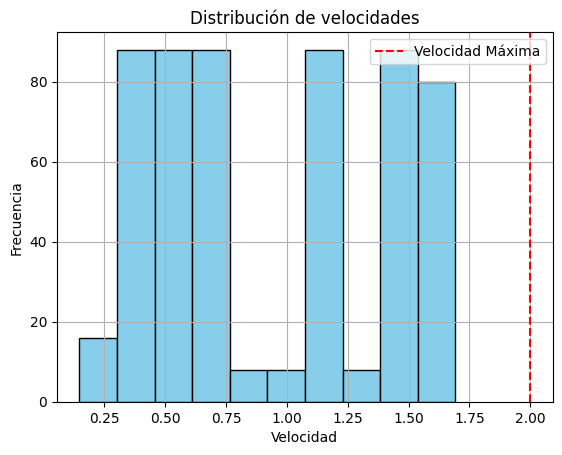

In [133]:
velocidad_max = 2
# print(velocities_list)

# Crear histograma
plt.hist(velocities_list, bins=10, color='skyblue', edgecolor='black')
plt.axvline(velocidad_max, color='red', linestyle='--', label='Velocidad Máxima')

plt.xlabel('Velocidad')
plt.ylabel('Frecuencia')
plt.title('Distribución de velocidades')
plt.legend()
plt.grid(True)
plt.savefig("Velocidades_en_edifico.png")
plt.show()

### Gráfico de las presiones a la salida de cada dispositivo

Dispositivo 1

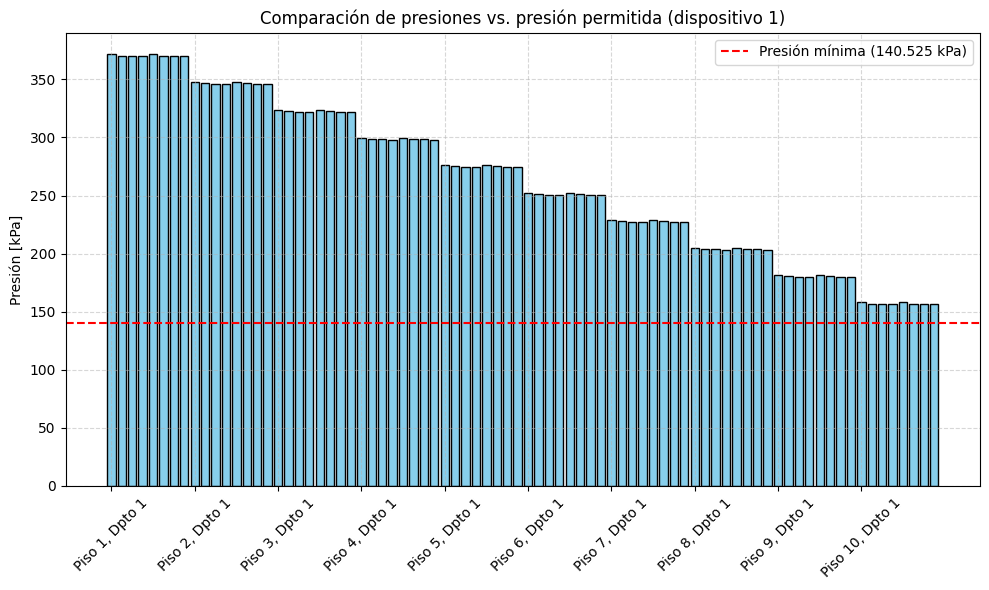

In [134]:
presion_minima = 140525/1e3  # Pa

etiquetas_list = []
presiones_list = []

# Crear gráfico de barras
plt.figure(figsize=(10, 6))
for i in range(len(ploter_table)):
    data = ploter_table[i]
    piso = data[0]
    departamento = data[1]
    presion = data[2]/1e3 # Presión del dispositivo 1
    etiqueta = f"Piso {piso}, Dpto {departamento}"
    etiquetas_list.append(etiqueta)
    presiones_list.append(presion)

plt.bar(etiquetas_list, presiones_list, color='skyblue', edgecolor='black')

# Línea horizontal de presión mínima
plt.axhline(y=presion_minima, color='red', linestyle='--', label=f'Presión mínima ({presion_minima:.3f} kPa)')

# Etiquetas y título
plt.ylabel('Presión [kPa]')
plt.title('Comparación de presiones vs. presión permitida (dispositivo 1)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
# Mostrar etiquetas cada 8 posiciones
step = 8
plt.xticks(ticks=range(0, len(etiquetas_list), step), labels=etiquetas_list[::step], rotation=45)

plt.tight_layout()
plt.savefig("Presiones_dispositivo_1.png")
plt.show()

Dispositivo 2

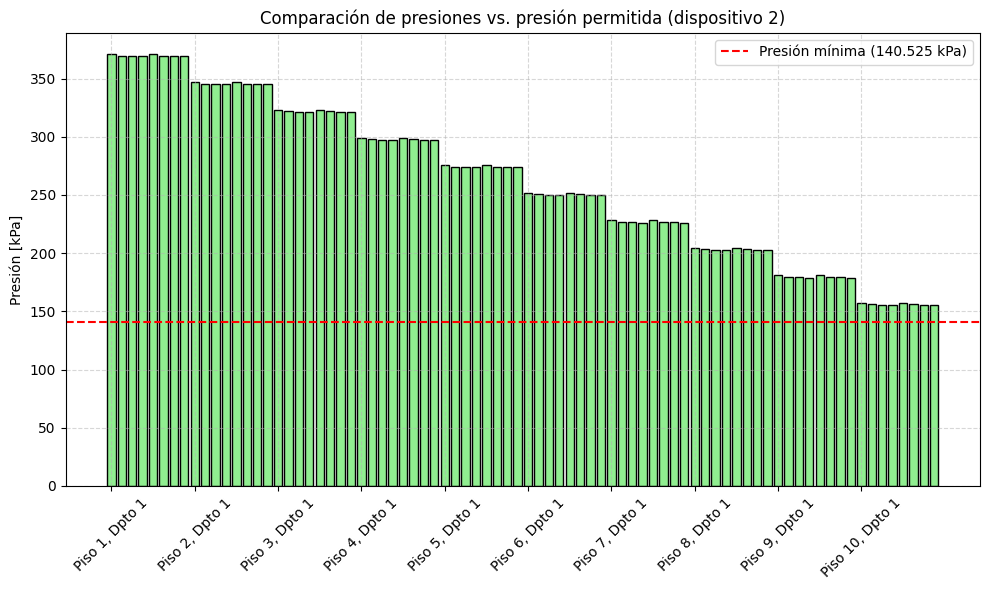

In [135]:
etiquetas_list = []
presiones_list = []

# Crear gráfico de barras
plt.figure(figsize=(10, 6))
for i in range(len(ploter_table)):
    data = ploter_table[i]
    piso = data[0]
    departamento = data[1]
    presion = data[3]/1e3 # Presión del dispositivo 2
    etiqueta = f"Piso {piso}, Dpto {departamento}"
    etiquetas_list.append(etiqueta)
    presiones_list.append(presion)

plt.bar(etiquetas_list, presiones_list, color='lightgreen', edgecolor='black')

# Línea horizontal de presión mínima
plt.axhline(y=presion_minima, color='red', linestyle='--', label=f'Presión mínima ({presion_minima:.3f} kPa)')

# Etiquetas y título
plt.ylabel('Presión [kPa]')
plt.title('Comparación de presiones vs. presión permitida (dispositivo 2)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
# Mostrar etiquetas cada 8 posiciones
step = 8
plt.xticks(ticks=range(0, len(etiquetas_list), step), labels=etiquetas_list[::step], rotation=45)

plt.tight_layout()
plt.savefig("Presiones_dispositivo_2.png")
plt.show()

Dispositivo 3

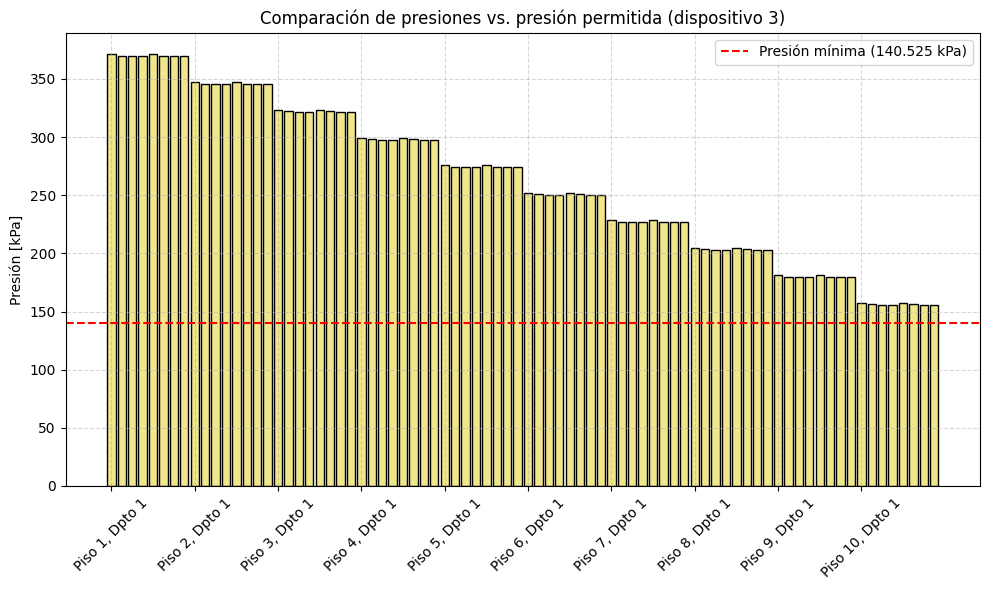

In [136]:
etiquetas_list = []
presiones_list = []

# Crear gráfico de barras
plt.figure(figsize=(10, 6))
for i in range(len(ploter_table)):
    data = ploter_table[i]
    piso = data[0]
    departamento = data[1]
    presion = data[4]/1e3 # Presión del dispositivo 3
    etiqueta = f"Piso {piso}, Dpto {departamento}"
    etiquetas_list.append(etiqueta)
    presiones_list.append(presion)

plt.bar(etiquetas_list, presiones_list, color='khaki', edgecolor='black')

# Línea horizontal de presión mínima
plt.axhline(y=presion_minima, color='red', linestyle='--', label=f'Presión mínima ({presion_minima:.3f} kPa)')

# Etiquetas y título
plt.ylabel('Presión [kPa]')
plt.title('Comparación de presiones vs. presión permitida (dispositivo 3)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
# Mostrar etiquetas cada 8 posiciones
step = 8
plt.xticks(ticks=range(0, len(etiquetas_list), step), labels=etiquetas_list[::step], rotation=45)

plt.tight_layout()
plt.savefig("Presiones_dispositivo_3.png")
plt.show()

### Cálculo del $\Delta P$ en la válvula reguladora por cada piso

/var/folders/tn/dyvt76z15n5_mr7pf5dg6w540000gn/T/ipykernel_35679/474544745.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


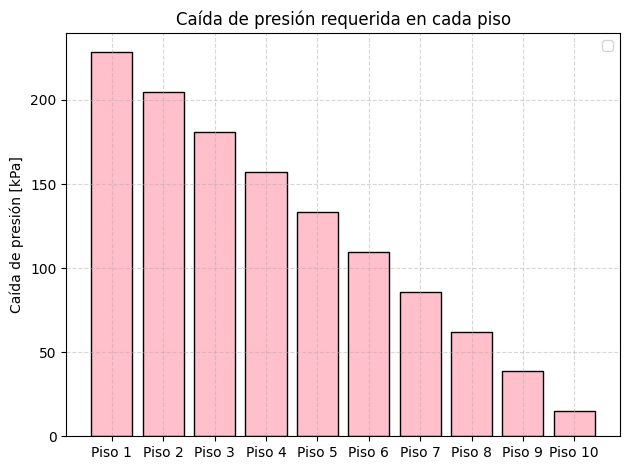

In [137]:
etiquetas_presiones = np.array([f"Piso {i+1}" for i in range(10)])

plt.bar(etiquetas_presiones, delta_presion_valvula, color='pink', edgecolor='black')

# Etiquetas y título
plt.ylabel('Caída de presión [kPa]')
plt.title('Caída de presión requerida en cada piso')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig("Valvulas_reguladoras.png")
plt.show()

### Gráfico de las presiones de salida considerando el delta de presión

Dispositivo 1

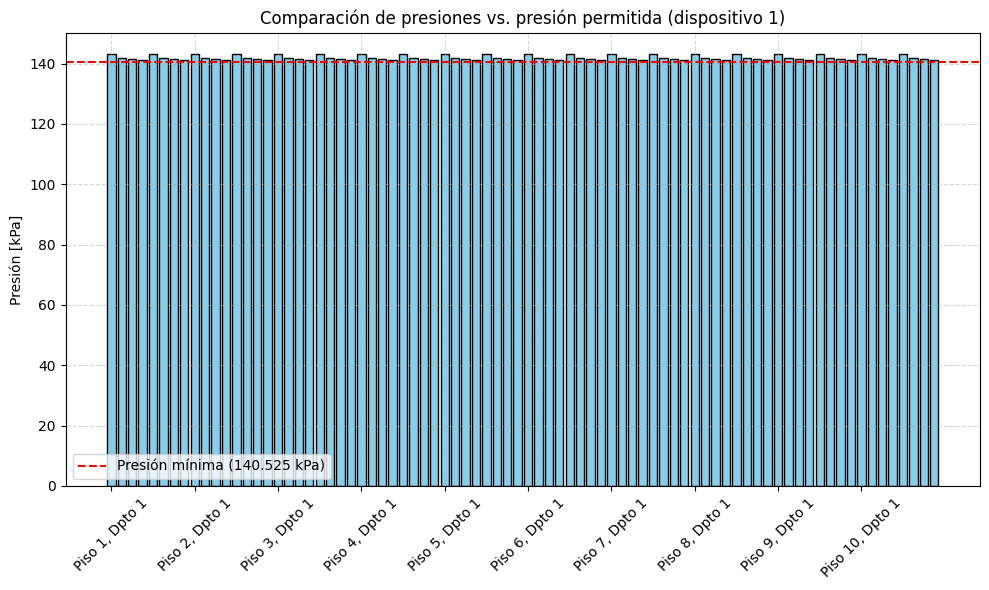

In [138]:
presion_minima = 140525/1e3  # Pa

etiquetas_list = []
presiones_list = []

# Crear gráfico de barras
plt.figure(figsize=(10, 6))
for i in range(len(ploter_table)):
    data = ploter_table[i]
    piso = data[0]
    departamento = data[1]
    presion = (data[2]/1e3) - delta_presion_valvula[int(piso) - 1] # Presión del dispositivo 1
    etiqueta = f"Piso {piso}, Dpto {departamento}"
    etiquetas_list.append(etiqueta)
    presiones_list.append(presion)

plt.bar(etiquetas_list, presiones_list, color='skyblue', edgecolor='black')

# Línea horizontal de presión mínima
plt.axhline(y=presion_minima, color='red', linestyle='--', label=f'Presión mínima ({presion_minima:.3f} kPa)')

# Etiquetas y título
plt.ylabel('Presión [kPa]')
plt.title('Comparación de presiones vs. presión permitida (dispositivo 1)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
# Mostrar etiquetas cada 8 posiciones
step = 8
plt.xticks(ticks=range(0, len(etiquetas_list), step), labels=etiquetas_list[::step], rotation=45)

plt.tight_layout()
plt.savefig("Presiones_dispositivo_1_reguladas.png")
plt.show()

Dispositivo 2

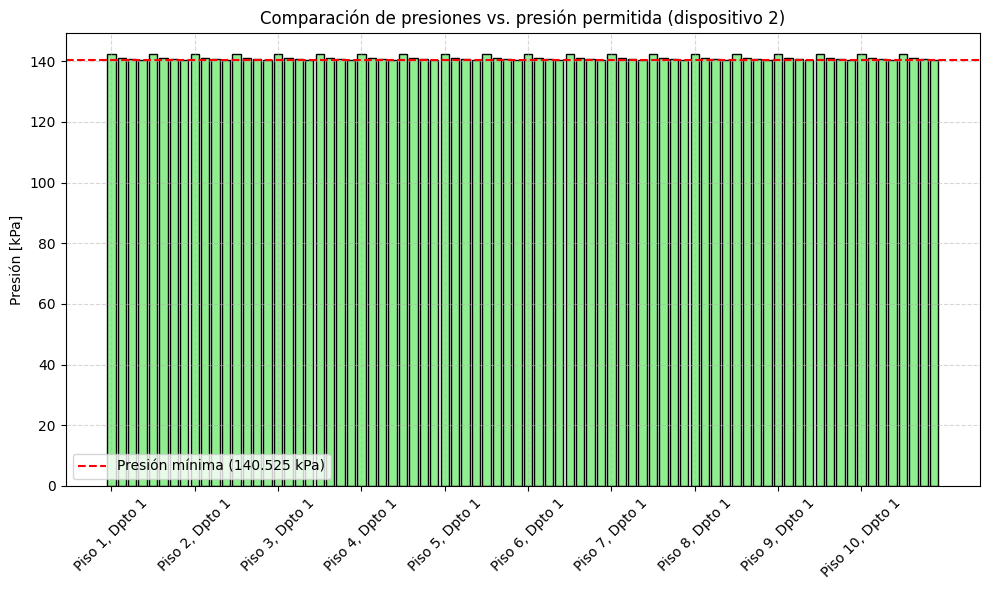

In [139]:
etiquetas_list = []
presiones_list = []

# Crear gráfico de barras
plt.figure(figsize=(10, 6))
for i in range(len(ploter_table)):
    data = ploter_table[i]
    piso = data[0]
    departamento = data[1]
    presion = (data[3]/1e3) - delta_presion_valvula[int(piso) - 1]
    etiqueta = f"Piso {piso}, Dpto {departamento}"
    etiquetas_list.append(etiqueta)
    presiones_list.append(presion)

plt.bar(etiquetas_list, presiones_list, color='lightgreen', edgecolor='black')

# Línea horizontal de presión mínima
plt.axhline(y=presion_minima, color='red', linestyle='--', label=f'Presión mínima ({presion_minima:.3f} kPa)')

# Etiquetas y título
plt.ylabel('Presión [kPa]')
plt.title('Comparación de presiones vs. presión permitida (dispositivo 2)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
# Mostrar etiquetas cada 8 posiciones
step = 8
plt.xticks(ticks=range(0, len(etiquetas_list), step), labels=etiquetas_list[::step], rotation=45)

plt.tight_layout()
plt.savefig("Presiones_dispositivo_2_reguladas.png")
plt.show()

Dispositivo 3

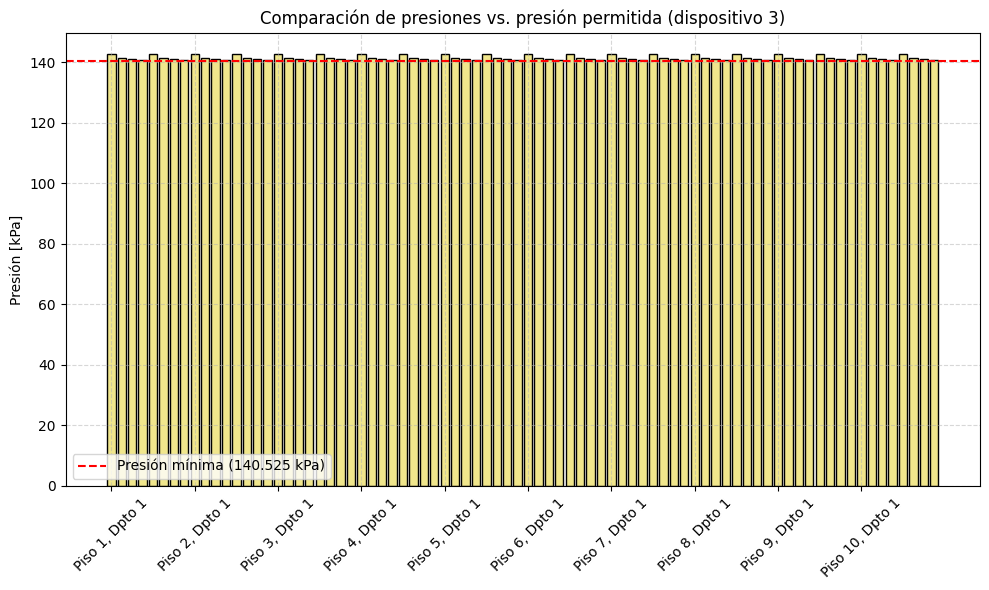

In [140]:
etiquetas_list = []
presiones_list = []

# Crear gráfico de barras
plt.figure(figsize=(10, 6))
for i in range(len(ploter_table)):
    data = ploter_table[i]
    piso = data[0]
    departamento = data[1]
    presion = (data[4]/1e3) - delta_presion_valvula[int(piso) - 1]
    etiqueta = f"Piso {piso}, Dpto {departamento}"
    etiquetas_list.append(etiqueta)
    presiones_list.append(presion)

plt.bar(etiquetas_list, presiones_list, color='khaki', edgecolor='black')

# Línea horizontal de presión mínima
plt.axhline(y=presion_minima, color='red', linestyle='--', label=f'Presión mínima ({presion_minima:.3f} kPa)')

# Etiquetas y título
plt.ylabel('Presión [kPa]')
plt.title('Comparación de presiones vs. presión permitida (dispositivo 3)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
# Mostrar etiquetas cada 8 posiciones
step = 8
plt.xticks(ticks=range(0, len(etiquetas_list), step), labels=etiquetas_list[::step], rotation=45)

plt.tight_layout()
plt.savefig("Presiones_dispositivo_3_reguladas.png")
plt.show()

### Selección de la bomba

Utilizando Bernoulli entre un punto antes y un punto después de la bomba, se tiene:

\begin{equation}
    \frac{P_{red}}{\gamma} + H_P = \frac{P_1}{\gamma}
\end{equation}

Además, se debe cumplir por normativa que la presión mínima del dispositivo más favorable debe ser de 0.392 [bar] (relativos, es decir, $P_2 = 101325 + 39200 = 140525 \;[Pa] = 140.525 \;[kPa]$).

Fuente: https://inspecthome.cl/wp-content/uploads/2024/04/nch-2485-of2000-instalaciones-domiciliarias-de-agua-potable.pdf

Presión de la red de agua: 

"A nivel de terreno sobre la tubería, la presión mínima de servicio en las tuberías de distribución, excluyendo el arranque, debe ser 147 kPa (1,5 kgf/cm2 = 15 mca), para el consumo máximo horario, con una pérdida de carga máxima de 49 kPa (5 mca) en el arranque."

Fuente: https://www.siss.gob.cl/appsiss/historico/w3-article-3841.html

$$ P_1 - P_2 = 265.527  \;[kPa]$$
De la presión mínima requerida se tiene:
$$ P_2 = 140.525 \;[kPa]$$
Por lo tanto:
$$ P_1 = 406.052 \;[kPa]$$

Con esto, y considerando que $P_{red} = 147 \;[kPa]$, entonces:

$$ H_P = \frac{P_1 - P_{red}}{\gamma} = \frac{403525 - 147000}{1000 \cdot 9.81} = 26.41 \;[m] = 85.65 \;[ft]$$


Por lo tanto, considerando un caudal de $Q_{P} = 5.67\;L/s = 89.87 \;GPM$ (https://www.unitjuggler.com/flowrate-convertir-ls-a-us-gpm.html?val=1.57198), entonces se pueden seleccionar la siguiente bomba:

### 4 x 13.5 a 1150 RPM (series e-80)

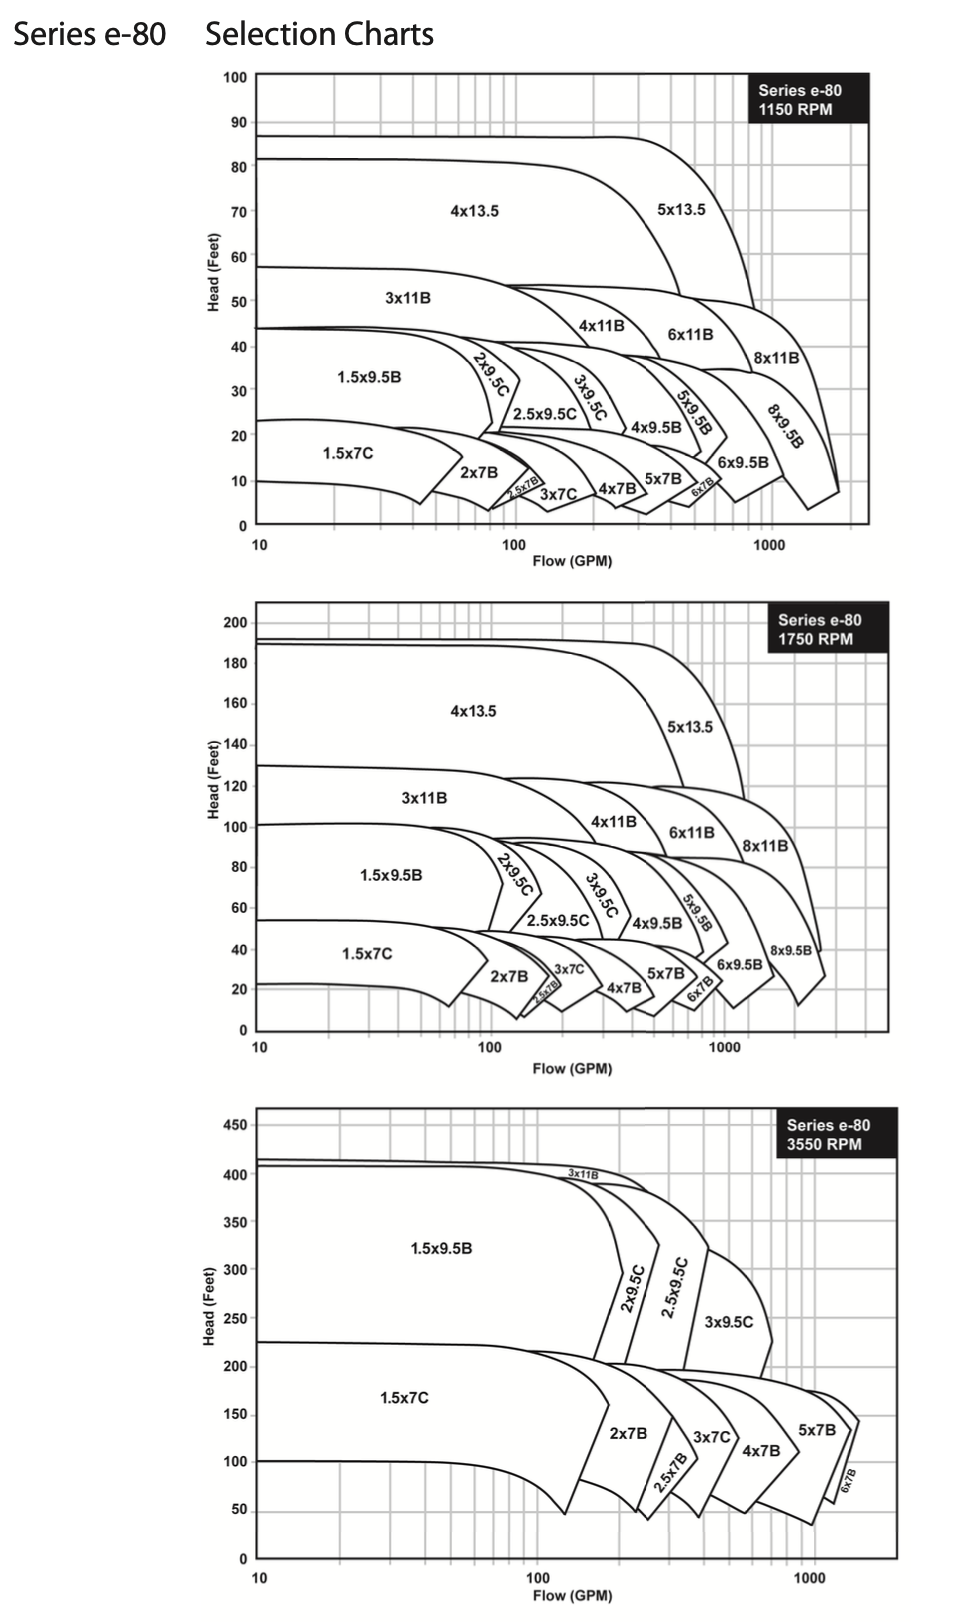